# Performance Evaluation

In [5]:
from datetime import timedelta
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display_functions import display

plt.rcParams['figure.figsize'] = (15, 10)
#plt.rcParams["figure.autolayout"] = True

experiments = [
    "ExperimentA",
    "ExperimentB",
    "ExperimentC",
    "ExperimentD",
    "ExperimentE"
]

with pd.HDFStore('../ExperimentAStore.h5') as store:
    experimentAStore = store['results'] if 'results' in store else None

with pd.HDFStore('../ExperimentBStore.h5') as store:
    experimentBStore = store['results'] if 'results' in store else None

with pd.HDFStore('../ExperimentCStore.h5') as store:
    experimentCStore = store['results'] if 'results' in store else None

with pd.HDFStore('../ExperimentDStore.h5') as store:
    experimentDStore = store['results'] if 'results' in store else None

with pd.HDFStore('../ExperimentEStore.h5') as store:
    experimentEStore = store['results'] if 'results' in store else None

humanTaskNames = {
    "infer": "OWL inference task (HermiT)",
    "sparql": "SPARQL (Jena ARQ)",
    "buildkb": "KB mapping",
    "shacl": "SHACL (Jena)"
}

taskColors = {
    "infer": "#0083CC",
    "sparql": "#F5A300",
    "buildkb": "#009D81",
    "shacl": "#C9308E"
}

taskOrder = {
    "buildkb": 0,
    "sparql": 1,
    "shacl": 2,
    "infer": 3,
}


def plotTime3D(store, metric, task):
    frame = store[metric].transform(lambda x: x[task])

    # setup the figure and axes
    fig = plt.figure()
    ax1 = fig.add_subplot(121, projection='3d')

    ax1.bar3d(frame)
    plt.show()


def plotTaskComparison(store, metric, frameTransform, labelMaker, ymax: Optional[float]):
    tasks = store[metric].iloc[0].keys()
    tasks = [task for task in tasks if task in humanTaskNames]
    tasks.sort(key=lambda x: taskOrder.get(x, max(taskOrder.values()) + 1))
    labels = store.index

    x = np.arange(len(labels))  # the label locations
    width = 0.8  # the width of the bars

    fig, ax = plt.subplots()

    idx = 0
    for task in tasks:
        frame = frameTransform(store[metric].transform(lambda x: x[task]))
        subfig = ax.bar((x + (idx * width / len(tasks))) - width / 2 + width / len(tasks) / 2, frame,
                        width=width / len(tasks), label=task, color=taskColors[task])
        ax.bar_label(subfig, labels=labelMaker(frame), padding=3)
        #fig.set_yscale('symlog')
        idx = idx + 1

        display(frame)

    plt.legend([humanTaskNames[task] for task in tasks])
    ax.set_xticks(x, labels)
    if ymax:
        ax.set_ylim([0, ymax])

    fig.tight_layout()
    plt.show()


def plotTaskTimeComparison(store, ymax):
    return plotTaskComparison(
        store,
        'times',
        lambda frame: frame.astype('timedelta64[ns]').transform(lambda x: x / timedelta(seconds=1)),
        lambda frame: ["{:.2f}s".format(f) for f in frame],
        ymax
    )


def plotTaskMemoryComparison(store, ymax):
    return plotTaskComparison(
        store,
        'memory',
        lambda frame: frame.transform(lambda x: x / (1024 * 1024)),
        lambda frame: ["{:.2f}MiB".format(v) for v in frame],
        ymax
    )


def plotAllStats(store):
    labels = store.index[0:2]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    for idx in labels:
        stats = store.loc[idx]['stats']
        idx = 0
        for key in stats:
            rects = ax.bar((x + (idx * width / len(stats))) - width / 2, stats[key], width, label=key)
            ax.bar_label(rects, padding=10)
            idx = idx + 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(x, labels)
    # ax.legend()

    fig.tight_layout()

    plt.show()


def plotStats(store, idx):
    statsDict = store.loc[idx]['stats']
    plt.bar(*zip(*statsDict.items()))

    all_axes = plt.gcf().get_axes()
    ax = all_axes[0]
    ax.set_yscale('symlog')

    plt.show()


def plot3D(store, task: str, metric: str, frameTransform, zlabel: Optional[str] = None, zmax: Optional[float] = None):
    frame = pd.DataFrame(store[metric].transform(lambda x: x[task]))
    display(frame)

    # setup the figure and axes
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')

    x = frame.index.get_level_values(0)
    y = frame.index.get_level_values(1)
    z = np.zeros_like(x)

    dx = dy = 50
    dz = np.array(frameTransform(frame.iloc[:, 0]))

    ax.set_xlabel('Classes')
    ax.set_ylabel('Instances')
    if zlabel is not None:
        ax.set_zlabel(zlabel)

    if zmax:
        ax.set_zlim([0, zmax])

    ax.bar3d(x, y, z, dx, dy, dz, color=taskColors[task])
    plt.show()


def plotTime3D(store, task, zmax: Optional[float] = None):
    plot3D(
        store,
        task,
        metric='times',
        frameTransform=lambda f: f.transform(lambda x: x.total_seconds()),
        zlabel='Time [s]',
        zmax=zmax
    )


def plotMemory3D(store, task, zmax: Optional[float] = None):
    plot3D(
        store,
        task,
        metric='memory',
        frameTransform=lambda f: f.transform(lambda x: x / (1024 * 1024)),
        zlabel='Peak Memory Usage [MiB]',
        zmax=zmax
    )

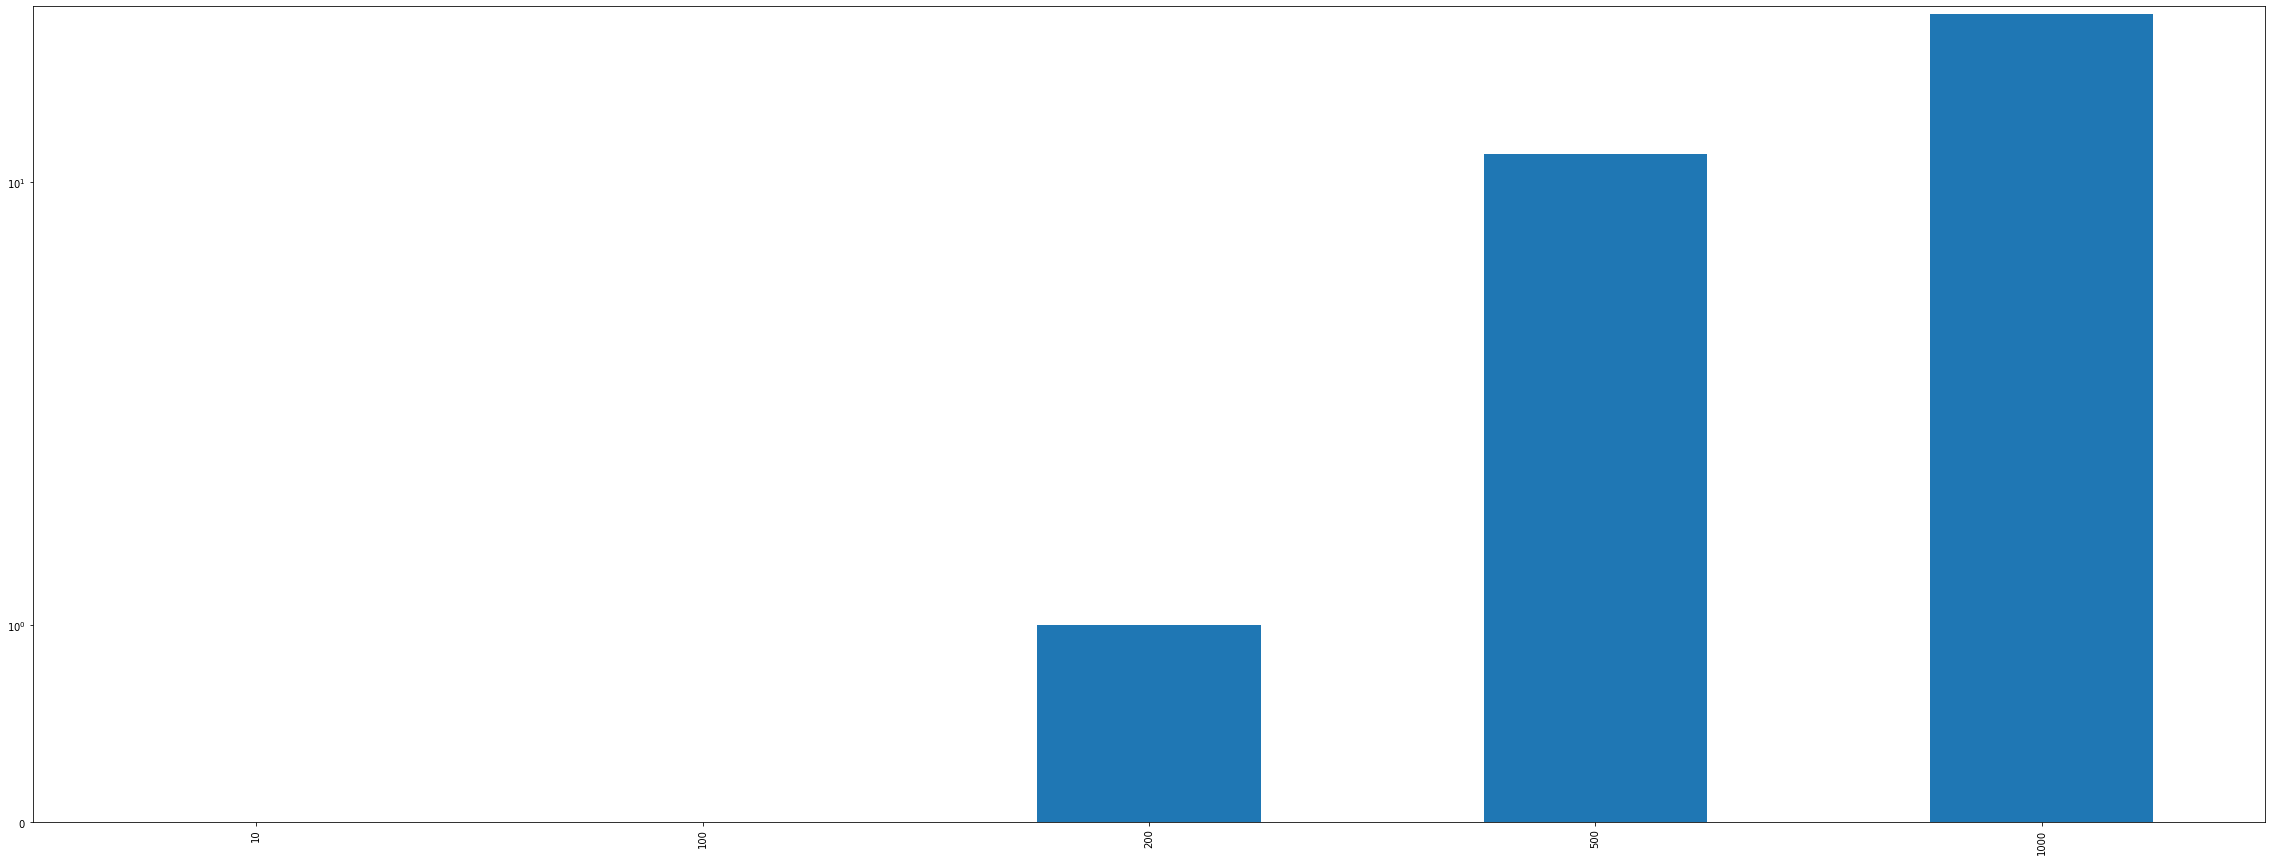

10     0 days 00:00:00.298505
100    0 days 00:00:00.526000
200    0 days 00:00:01.288756
500    0 days 00:00:12.481838
1000          0 days 00:00:30
Name: time, dtype: timedelta64[ns]

In [101]:
plotTime(instancesStore)

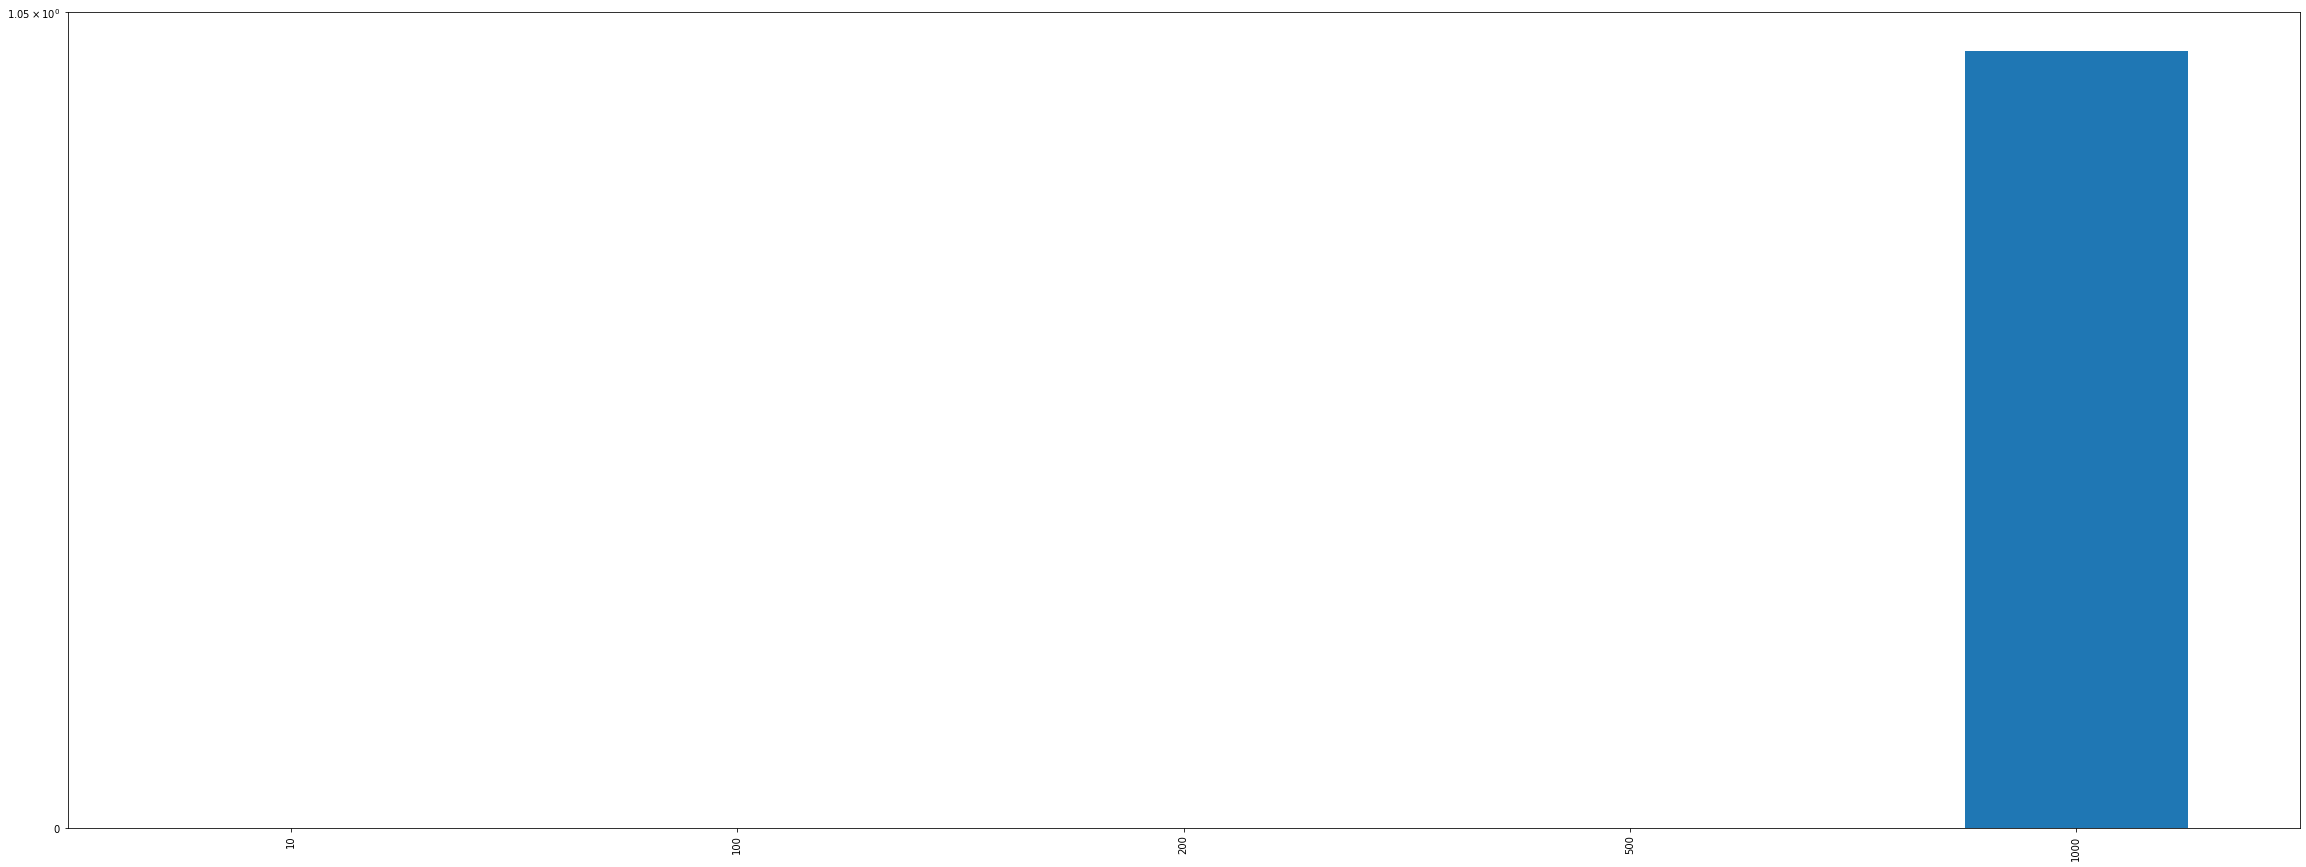

10     0 days 00:00:00.812281
100    0 days 00:00:00.842802
200    0 days 00:00:00.819462
500    0 days 00:00:00.824602
1000   0 days 00:00:01.004930
Name: time, dtype: timedelta64[ns]

In [105]:
plotTime(classesStore)

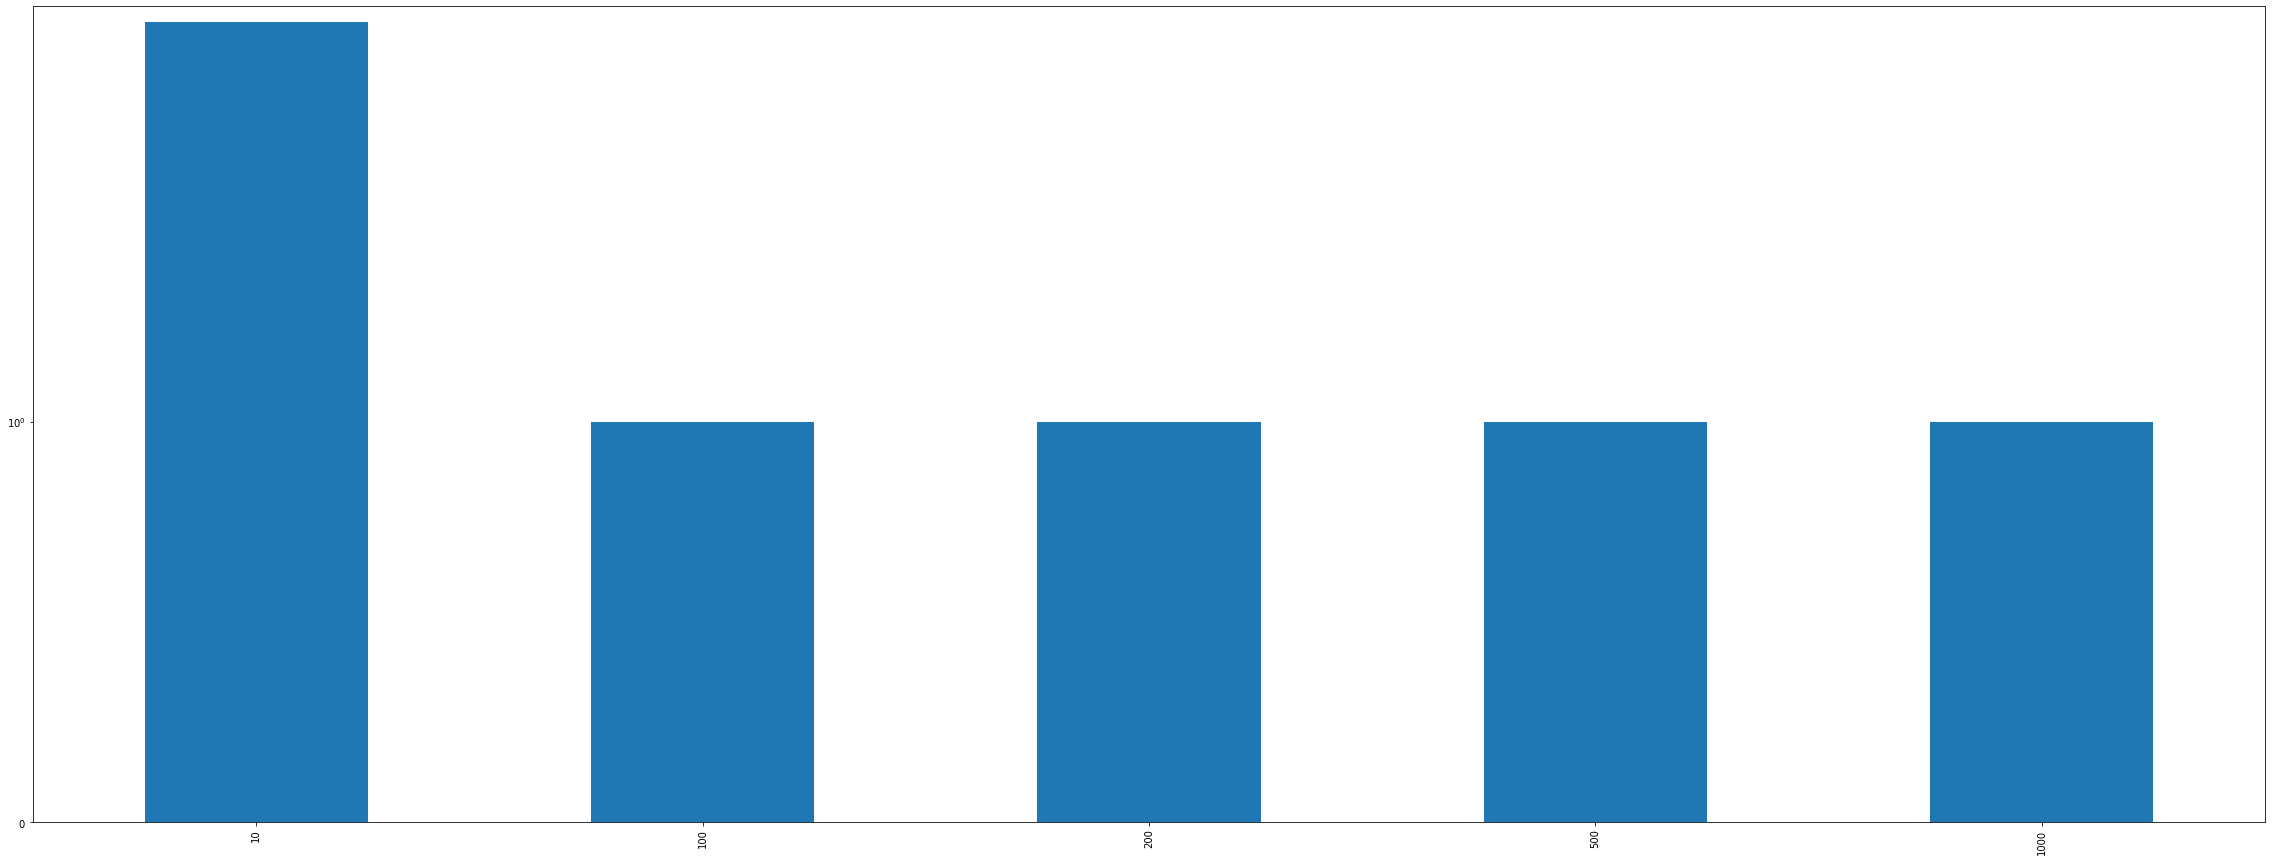

10     0 days 00:00:02.057648
100    0 days 00:00:01.516574
200    0 days 00:00:01.327436
500    0 days 00:00:01.357942
1000   0 days 00:00:01.384977
Name: time, dtype: timedelta64[ns]

In [109]:
plotTime(instancesAndClassesStore)

# Instances Task

* the number of classes does not seem to affect reasoning time much at all
* not that surprising, since the number of instances being queried was low (1)

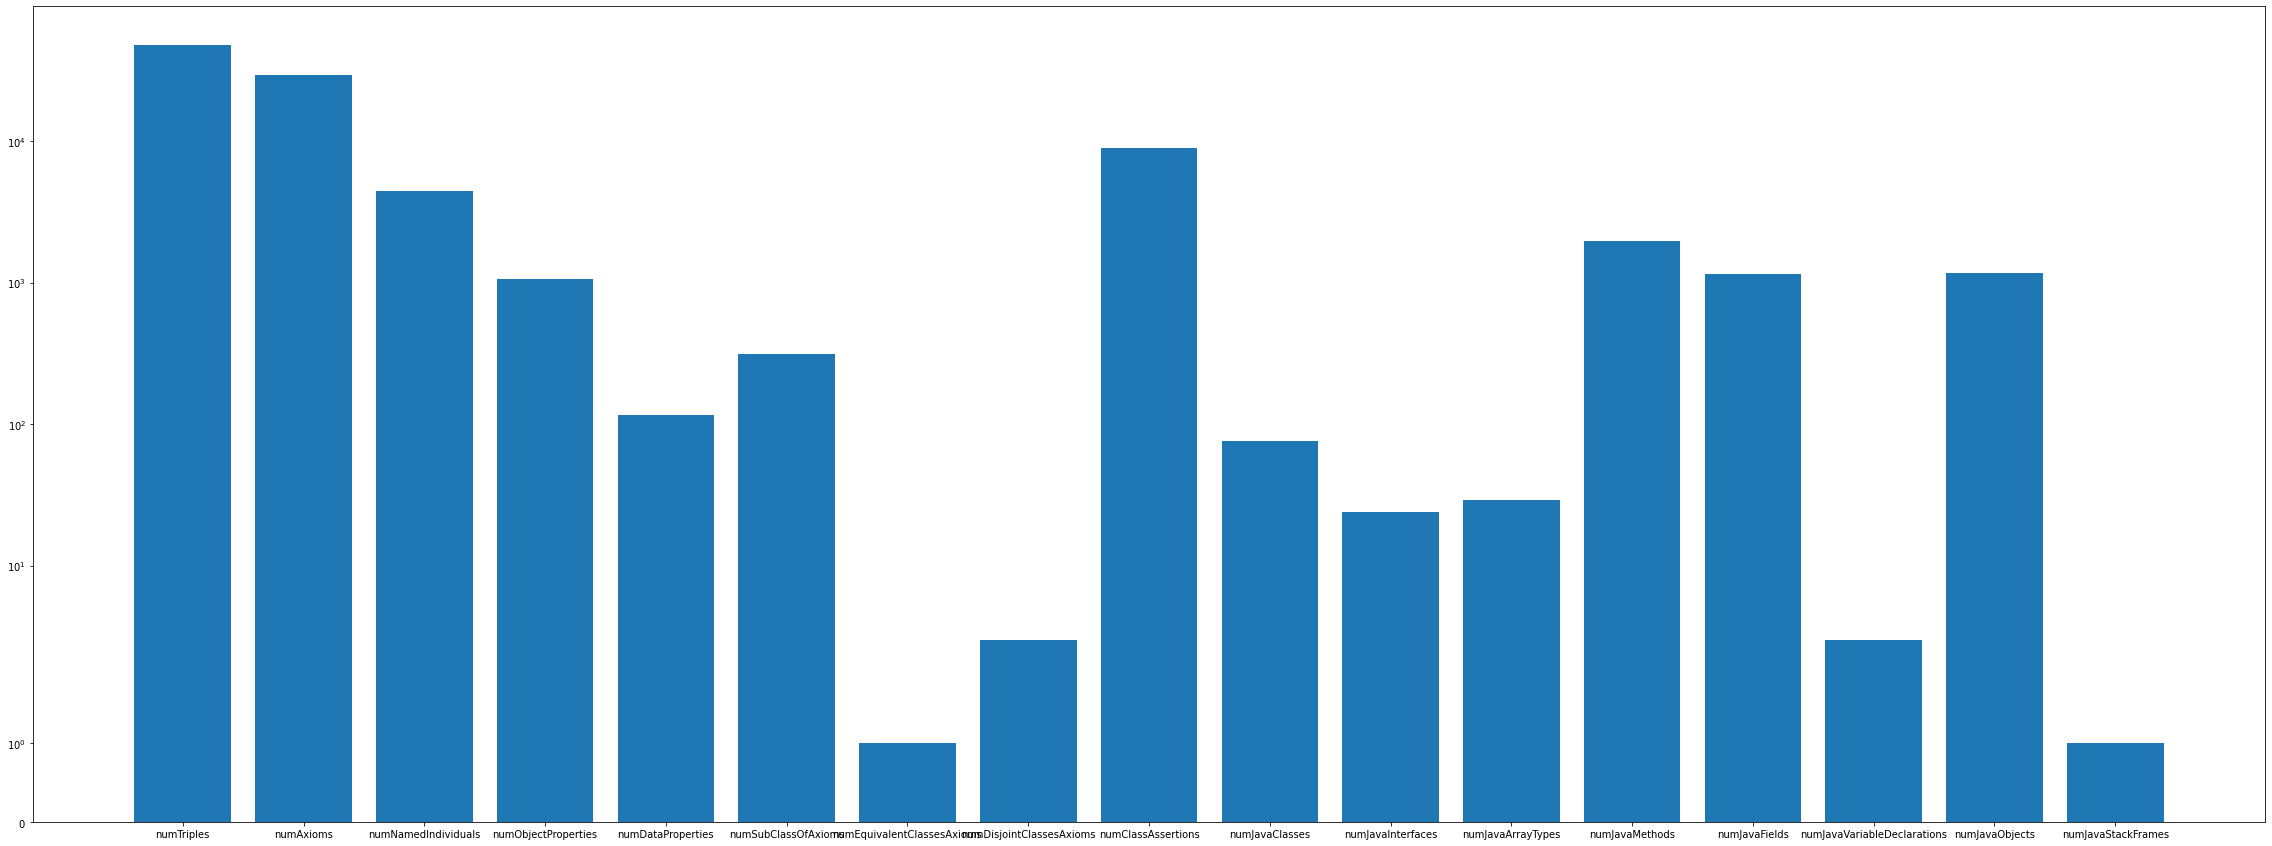

In [102]:
plotStats(instancesStore, 1000)

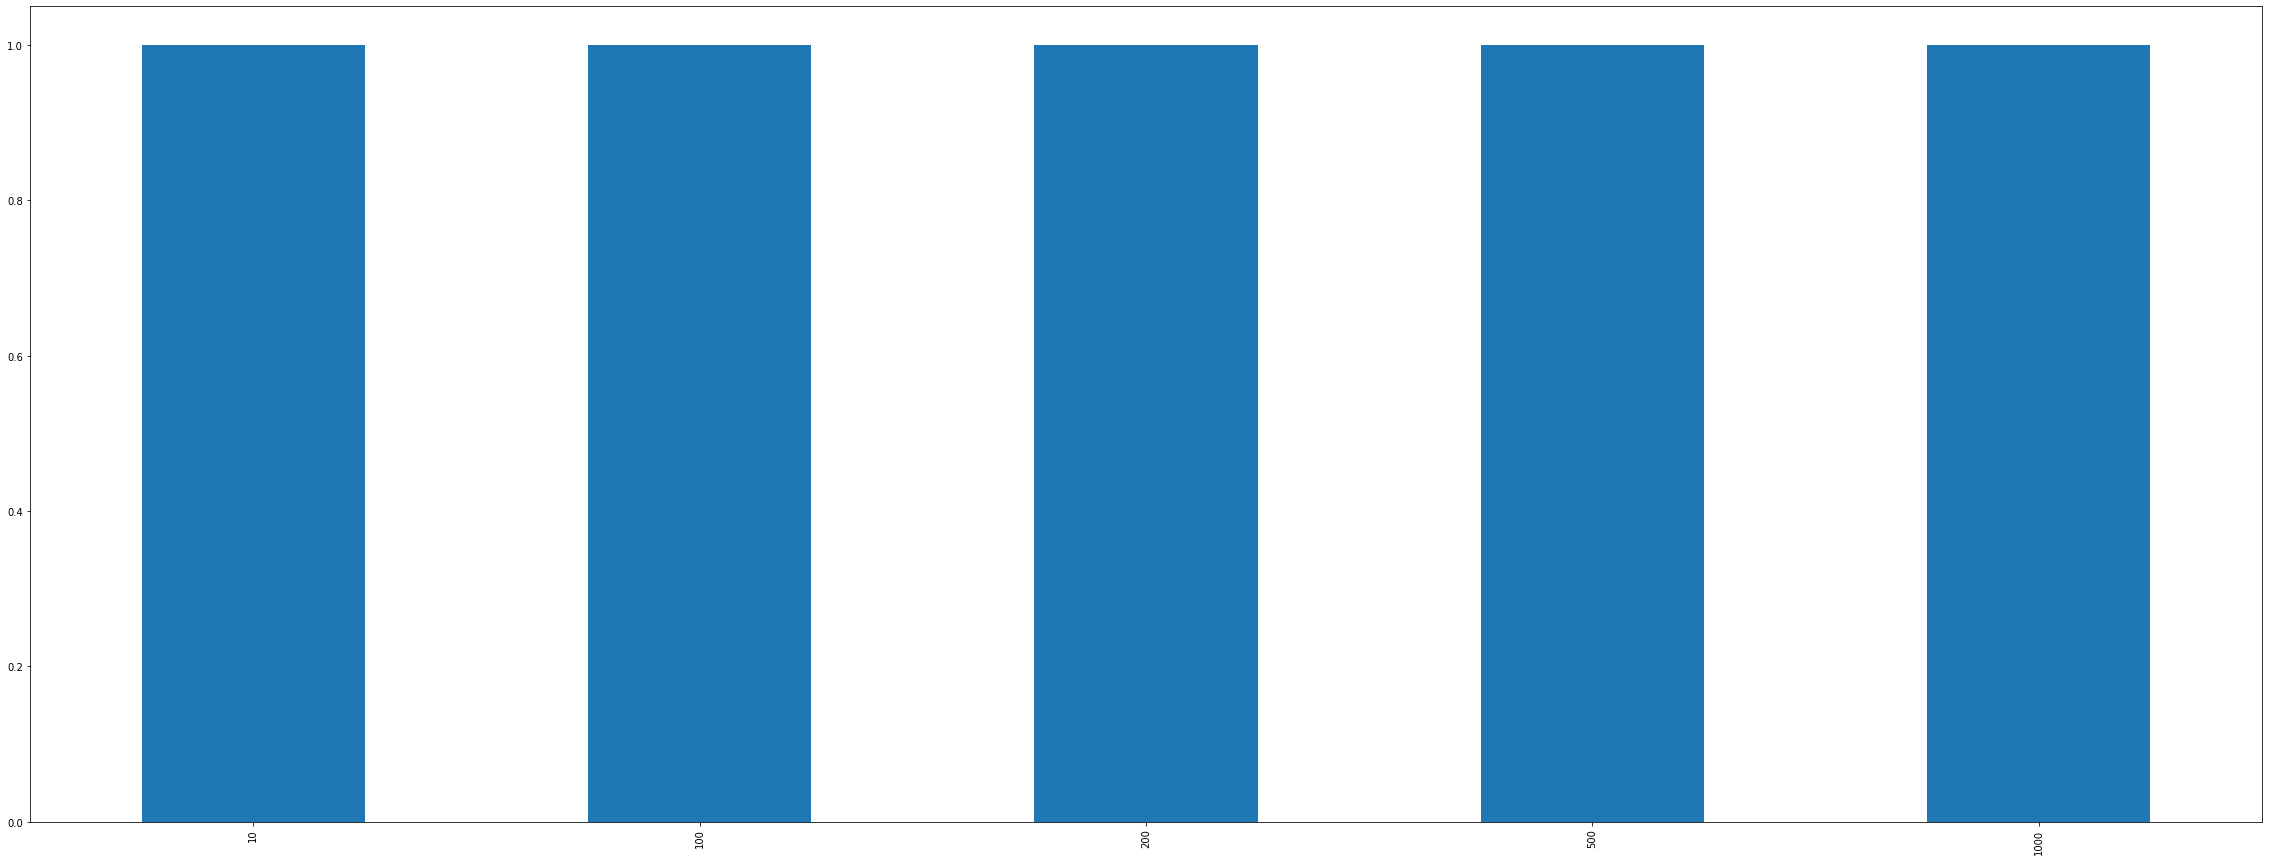

10     0 days 00:00:01.341753
100    0 days 00:00:01.415950
200    0 days 00:00:01.245653
500    0 days 00:00:01.666645
1000   0 days 00:00:01.933969
Name: times, dtype: timedelta64[ns]

In [127]:
plotTime(instancesStore, 'instancesInf')

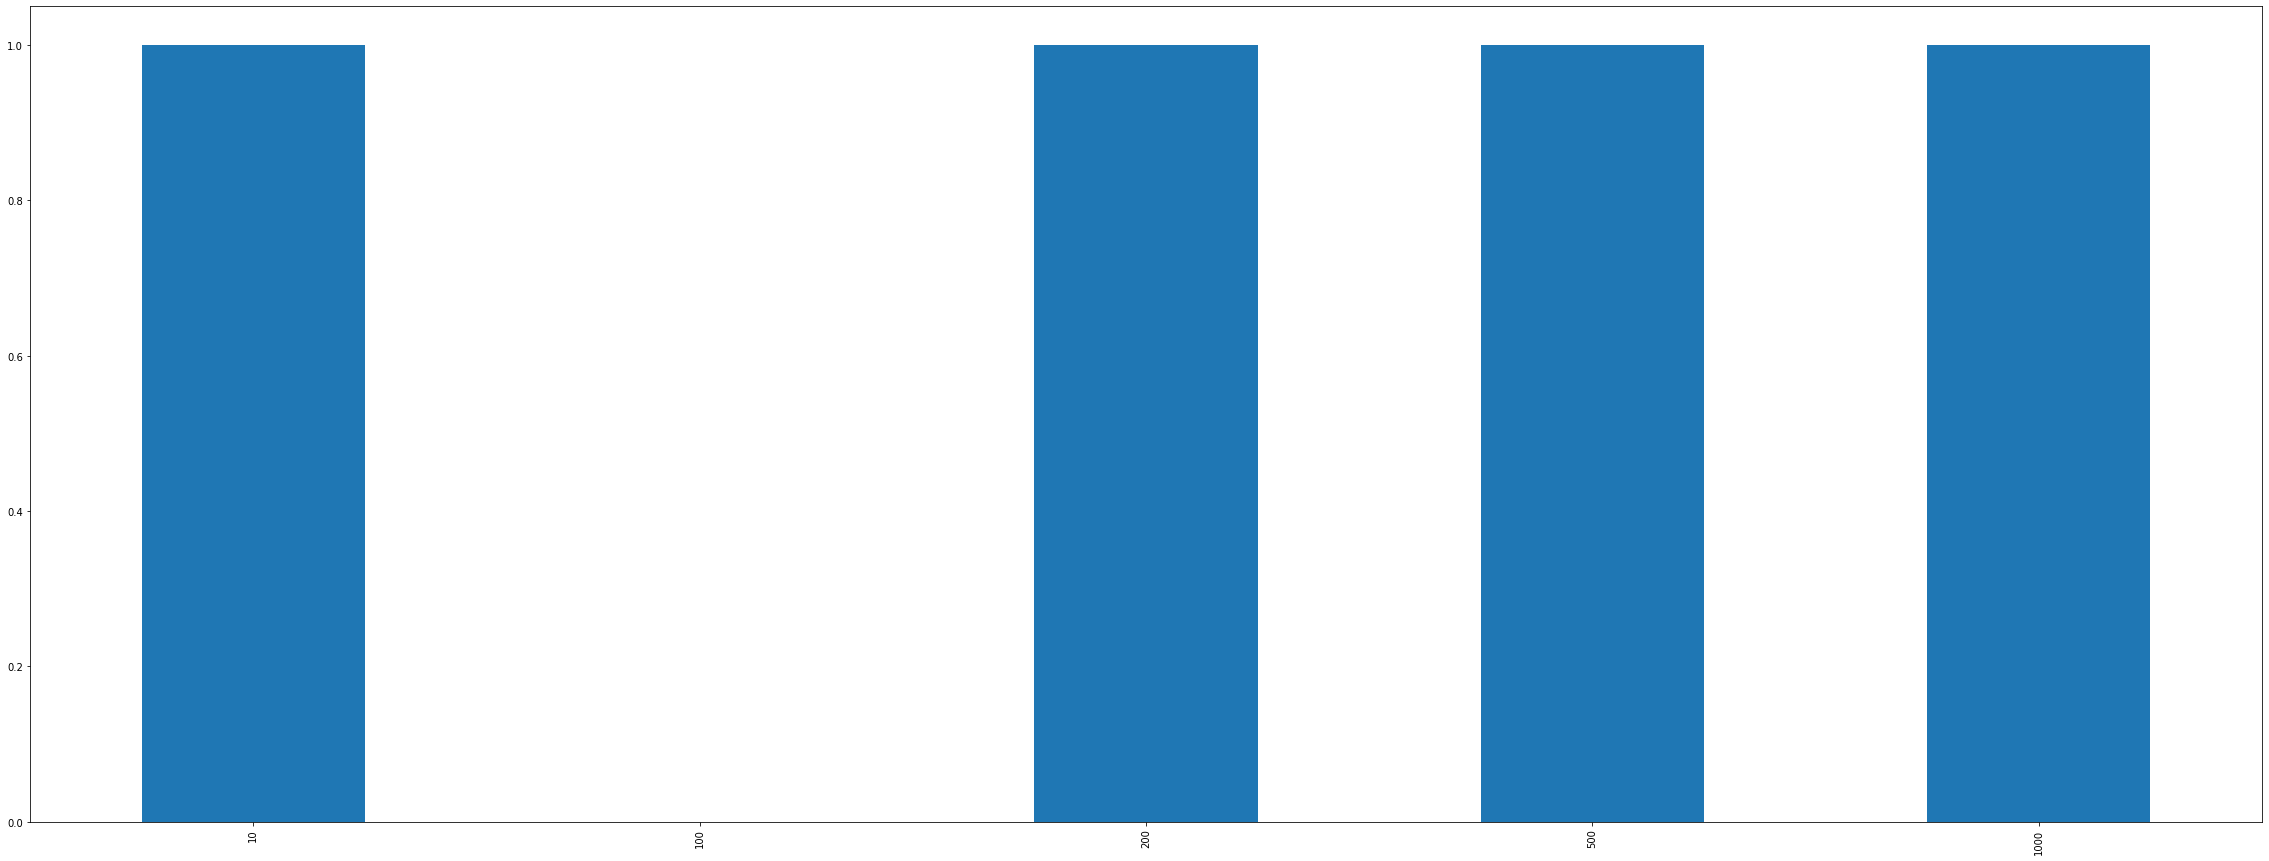

10     0 days 00:00:01.064348
100    0 days 00:00:00.984741
200    0 days 00:00:01.162026
500    0 days 00:00:01.177927
1000   0 days 00:00:01.068332
Name: times, dtype: timedelta64[ns]

In [128]:
plotTime(classesStore, 'instancesInf')

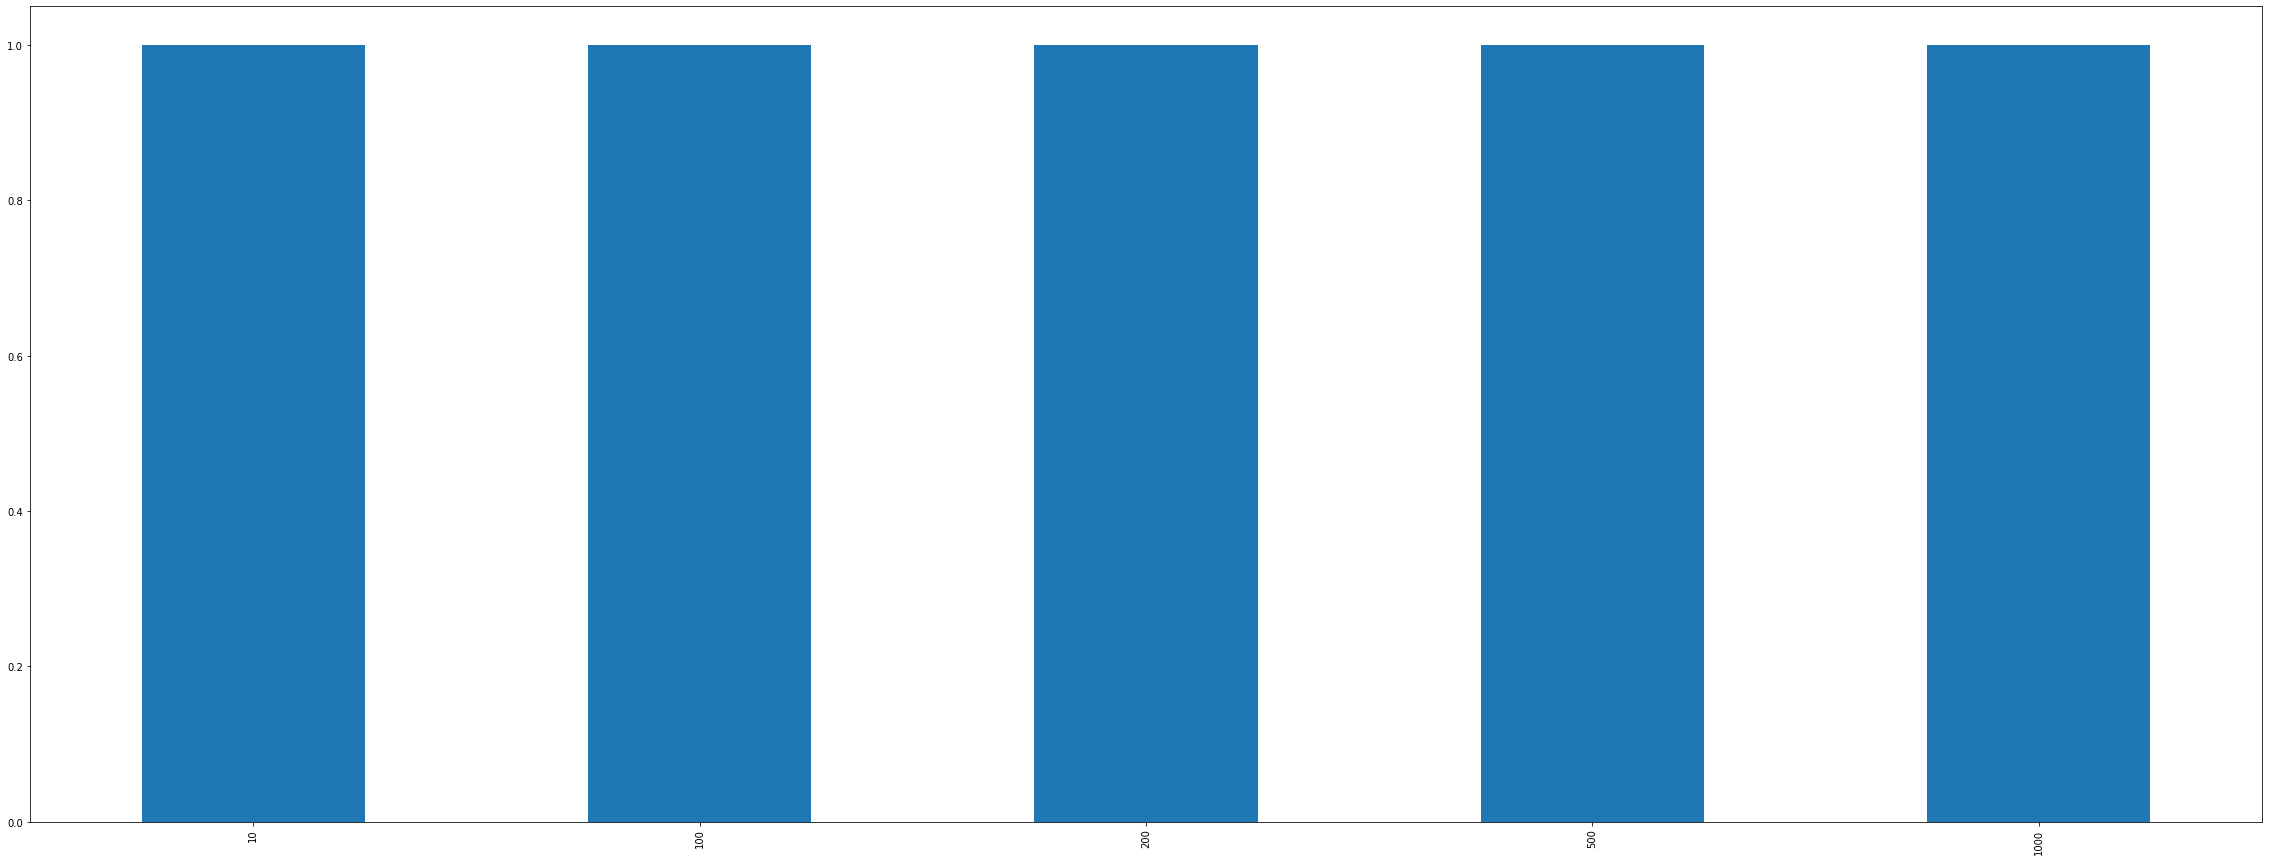

10     0 days 00:00:01.350837
100    0 days 00:00:01.270844
200    0 days 00:00:01.381213
500    0 days 00:00:01.447171
1000   0 days 00:00:01.578023
Name: times, dtype: timedelta64[ns]

In [129]:
plotTime(instancesAndClassesStore, 'instancesInf')

In [134]:
plotTime(instancesAndClassesEqualizedInstanceCountsStore, 'instancesInf')

ValueError: Transform function failed

10      1.341753
100     1.415950
200     1.245653
500     1.666645
1000    1.933969
Name: times, dtype: float64

10      0.259483
100     0.262176
200     0.267139
500     0.241796
1000    0.284551
Name: times, dtype: float64

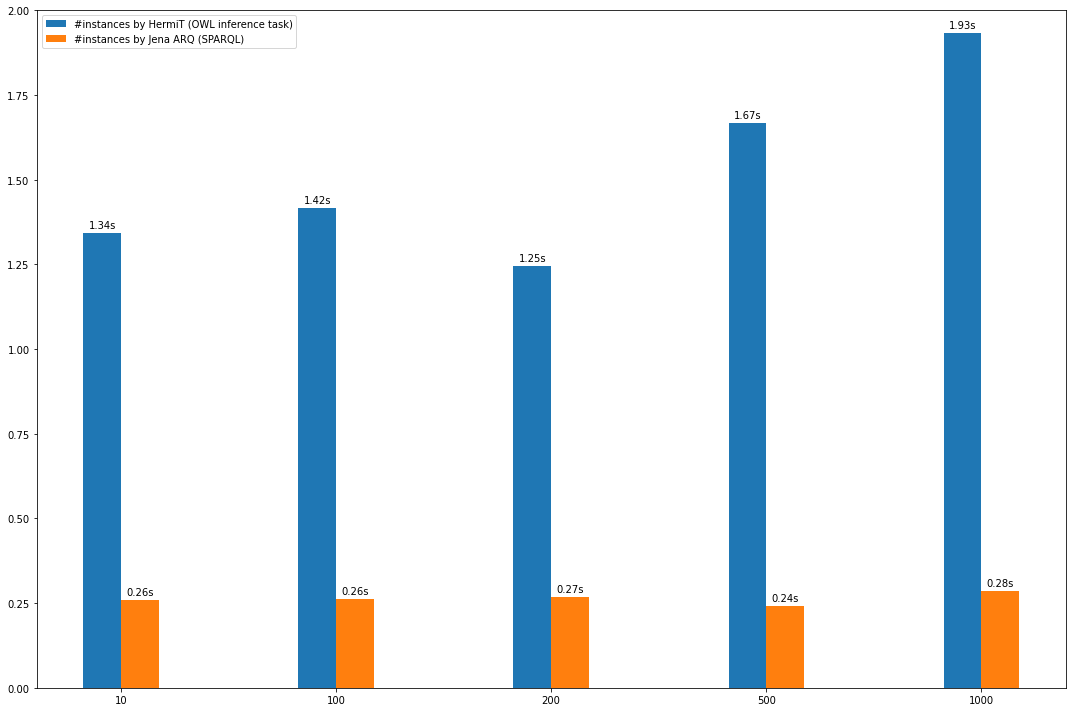

In [285]:
plotTaskTimeComparison(instancesStore, ymax=2).savefig("instances.jpg")

10      1.064348
100     0.984741
200     1.162026
500     1.177927
1000    1.068332
Name: times, dtype: float64

10      0.213847
100     0.187679
200     0.146644
500     0.141196
1000    0.157120
Name: times, dtype: float64

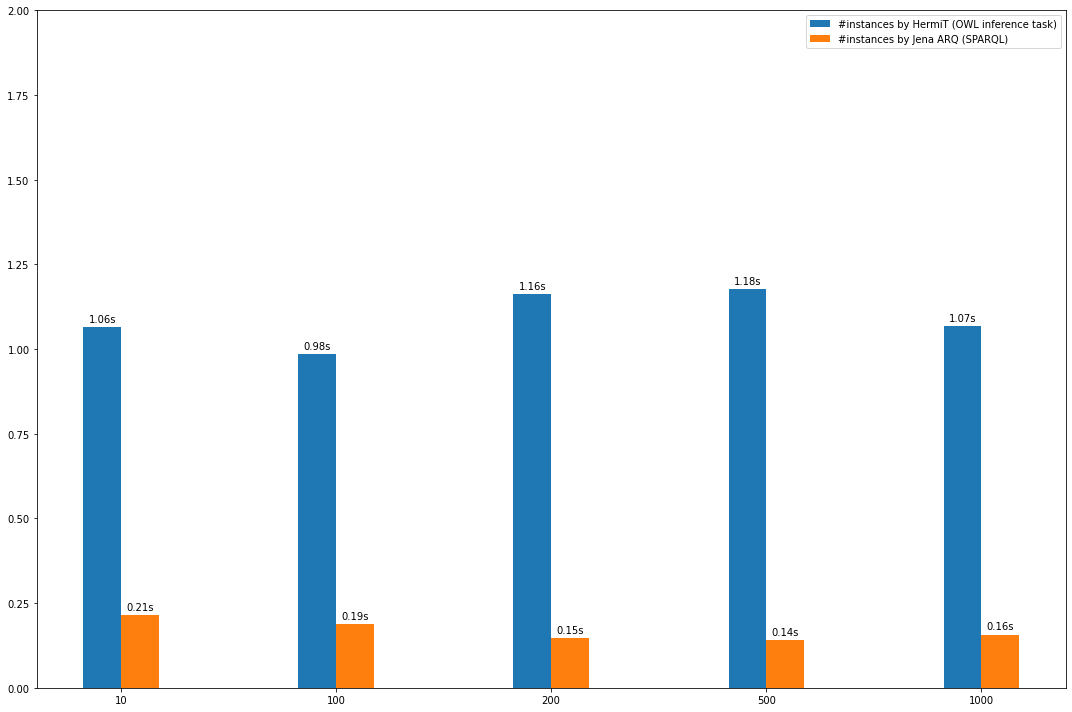

In [286]:
plotTaskTimeComparison(classesStore, ymax=2).savefig('classes.jpg')

10      1.350837
100     1.270844
200     1.381213
500     1.447171
1000    1.578023
Name: times, dtype: float64

10      0.201155
100     0.184803
200     0.150936
500     0.179436
1000    0.179760
Name: times, dtype: float64

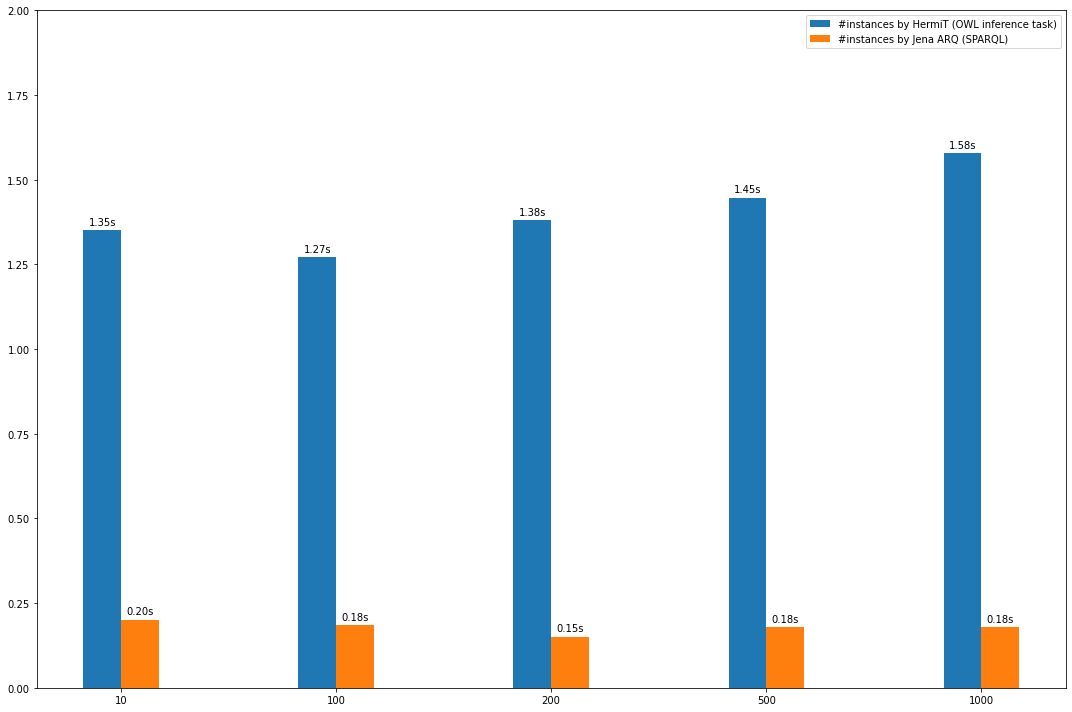

In [287]:
plotTaskTimeComparison(instancesAndClassesStore, ymax=2).savefig('instancesAndClasses.jpg')

<img src=instances.jpg width=600 /> <img src="classes.jpg" width=600/> 
<img src="instancesAndClasses.jpg" width=600/> 

10      1.004985
100     1.924329
200     3.192536
500     8.382650
1000    8.284960
Name: times, dtype: float64

10      0.148689
100     0.134031
200     0.107844
500     0.104279
1000    0.103185
Name: times, dtype: float64

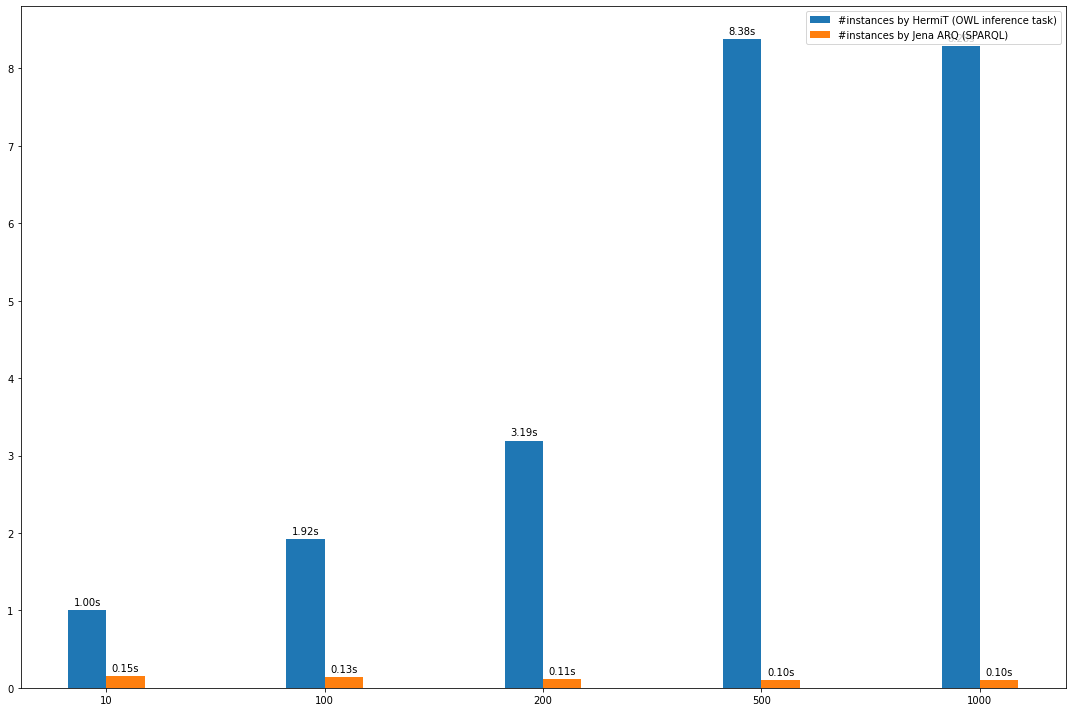

In [310]:
plotTaskTimeComparison(instancesAndClassesEqualizedInstanceCountsStore, ymax=None).savefig(
    'instancesAndClassesEqualizedInstanceCounts.jpg')

In [326]:
#plotTime3D('instancesInf')

times
100  100  0 days 00:00:03.158049
     200  0 days 00:00:02.644085
     300  0 days 00:00:02.516693
     400  0 days 00:00:02.531946
     500  0 days 00:00:03.837904
...                          ...
1000 600  0 days 00:00:16.824974
     700  0 days 00:00:22.427706
     800  0 days 00:00:32.343030
     900  0 days 00:00:48.056326
     1000 0 days 00:00:52.446649

[100 rows x 1 columns]

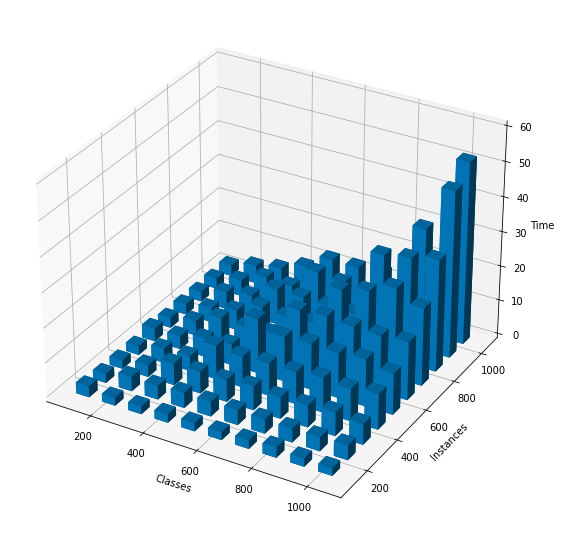

In [397]:
time3D('instancesInf', zmax=60)

times
100  100  0 days 00:00:00.204955
     200  0 days 00:00:00.167803
     300  0 days 00:00:00.155735
     400  0 days 00:00:00.157916
     500  0 days 00:00:00.233195
...                          ...
1000 600  0 days 00:00:00.149386
     700  0 days 00:00:00.151618
     800  0 days 00:00:00.150045
     900  0 days 00:00:00.172715
     1000 0 days 00:00:00.204742

[100 rows x 1 columns]

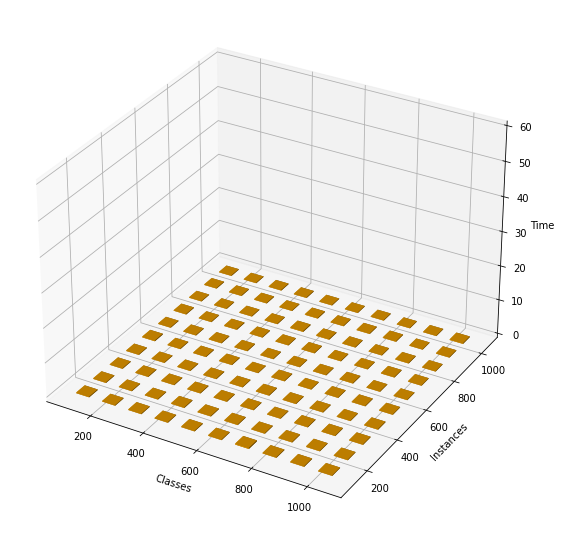

In [396]:
time3D('instancesSparql', zmax=60)

times
100  100  0 days 00:00:05.297562
     200  0 days 00:00:06.227938
     300  0 days 00:00:05.714390
     400  0 days 00:00:05.877687
     500  0 days 00:00:06.765099
...                          ...
1000 600  0 days 00:00:15.489749
     700  0 days 00:00:20.406993
     800  0 days 00:00:21.618407
     900  0 days 00:00:27.032216
     1000 0 days 00:00:31.222250

[100 rows x 1 columns]

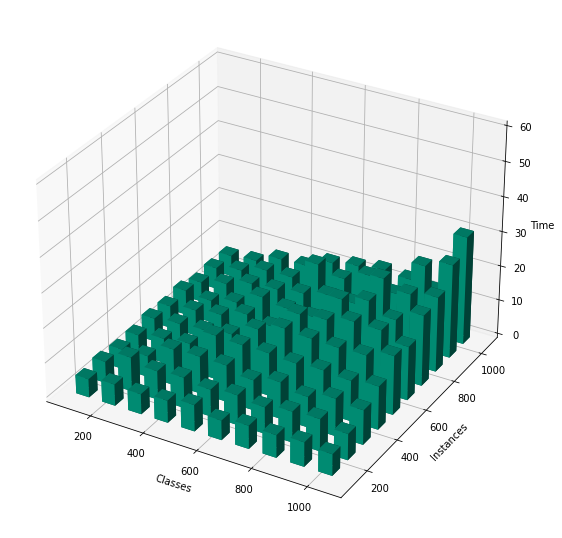

In [395]:
time3D('buildkb', zmax=60)

# Experiment A

100     3.898804
200     2.860494
300     2.452366
400     2.557107
500     2.609341
600     3.484059
700     2.858466
800     3.622392
900     2.851864
1000    3.073580
Name: times, dtype: float64

100     0.146874
200     0.236604
300     0.159559
400     0.179422
500     0.194677
600     0.149912
700     0.161493
800     0.210522
900     0.192132
1000    0.239249
Name: times, dtype: float64

100     1.867794
200     2.693119
300     1.926431
400     2.248238
500     2.966840
600     2.102480
700     2.263876
800     2.380510
900     2.690660
1000    2.281307
Name: times, dtype: float64

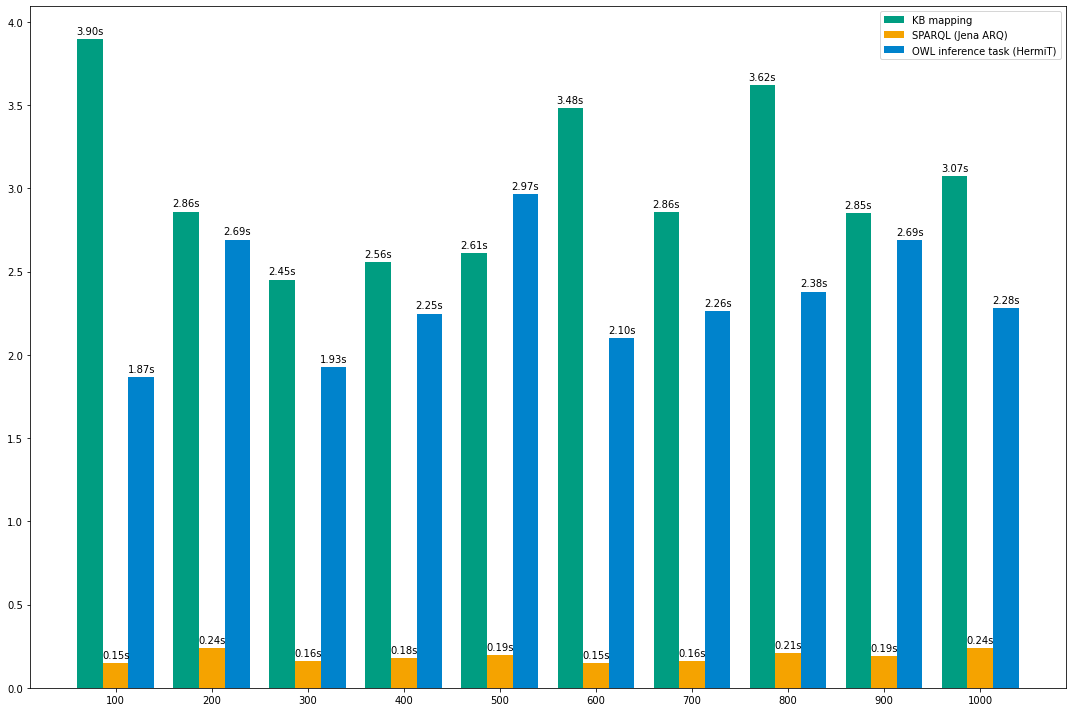

In [15]:
plotTaskTimeComparison(experimentAStore, ymax=None)

100     142.027504
200     142.879890
300     140.748520
400     141.252869
500     144.718735
600     144.951180
700     145.002251
800     142.712486
900     145.460670
1000    145.581917
Name: memory, dtype: float64

100     146.003403
200     144.633919
300     147.394630
400     148.283669
500     148.301109
600     148.658195
700     166.616646
800     149.558029
900     150.103165
1000    148.068954
Name: memory, dtype: float64

100     251.672043
200     266.414513
300     278.923706
400     289.514580
500     261.138680
600     228.501915
700     246.839447
800     236.128609
900     233.520927
1000    242.252174
Name: memory, dtype: float64

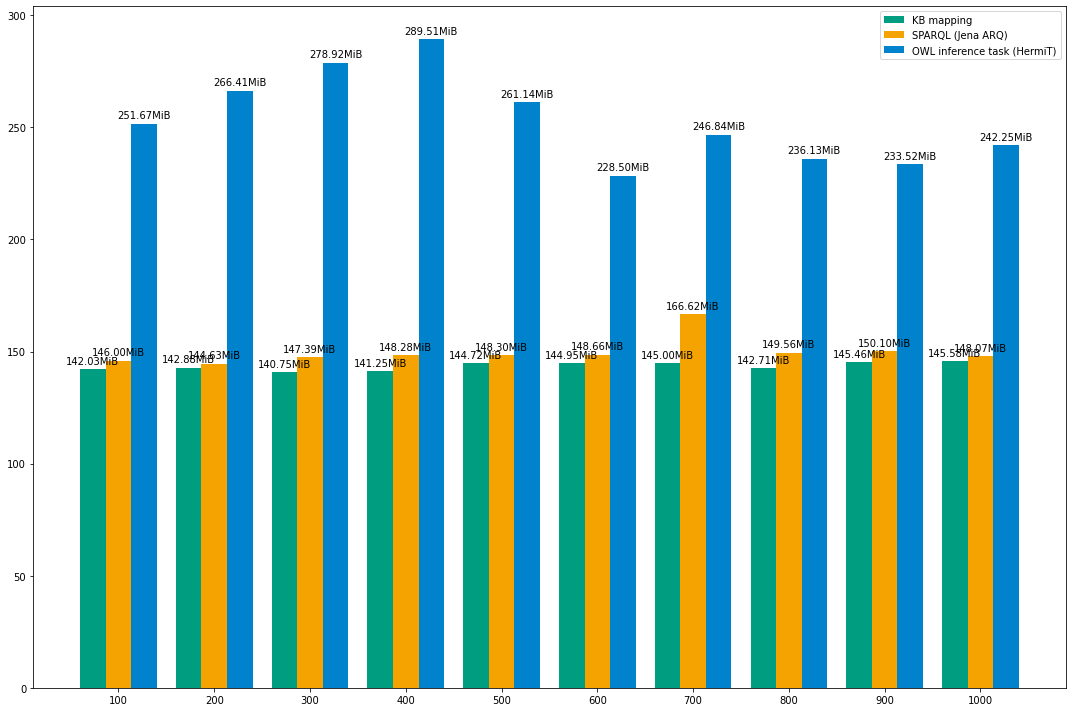

In [16]:
plotTaskMemoryComparison(experimentAStore, ymax=None)

# Experiment B

100     2.567627
200     3.173160
300     2.674238
400     3.480836
500     3.464140
600     3.908322
700     3.504493
800     3.355227
900     3.815155
1000    3.948507
Name: times, dtype: float64

100     0.134551
200     0.139161
300     0.132607
400     0.175310
500     0.231764
600     0.182125
700     0.222931
800     0.151936
900     0.132625
1000    0.136798
Name: times, dtype: float64

100     1.580696
200     1.666085
300     2.437068
400     2.020626
500     1.821213
600     1.668435
700     1.604647
800     1.598864
900     1.537304
1000    1.756303
Name: times, dtype: float64

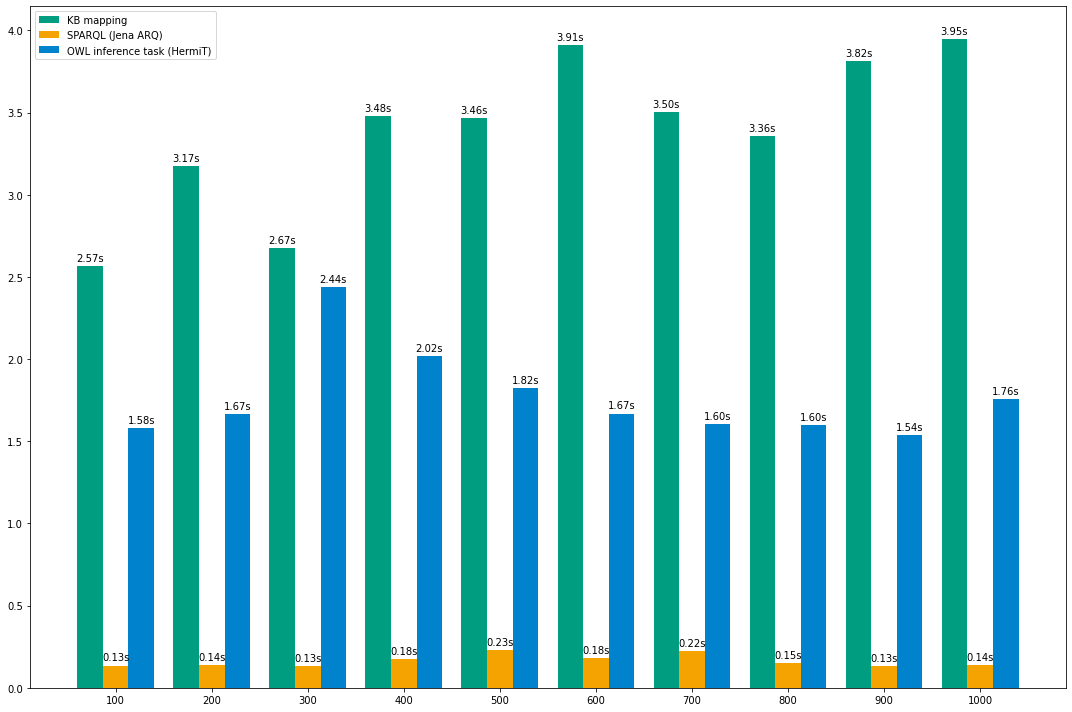

In [30]:
plotTaskTimeComparison(experimentBStore, ymax=None)

100     139.111954
200     142.980469
300     144.063850
400     142.942322
500     151.243233
600     155.323921
700     162.544449
800     159.814964
900     162.522125
1000    185.252686
Name: memory, dtype: float64

100     150.561966
200     154.878136
300     160.943481
400     148.232872
500     167.120888
600     170.086845
700     171.635529
800     171.244392
900     175.881683
1000    191.356270
Name: memory, dtype: float64

100     246.868607
200     233.755219
300     215.055145
400     237.193451
500     249.562233
600     247.392632
700     236.407623
800     328.509254
900     231.733948
1000    248.819244
Name: memory, dtype: float64

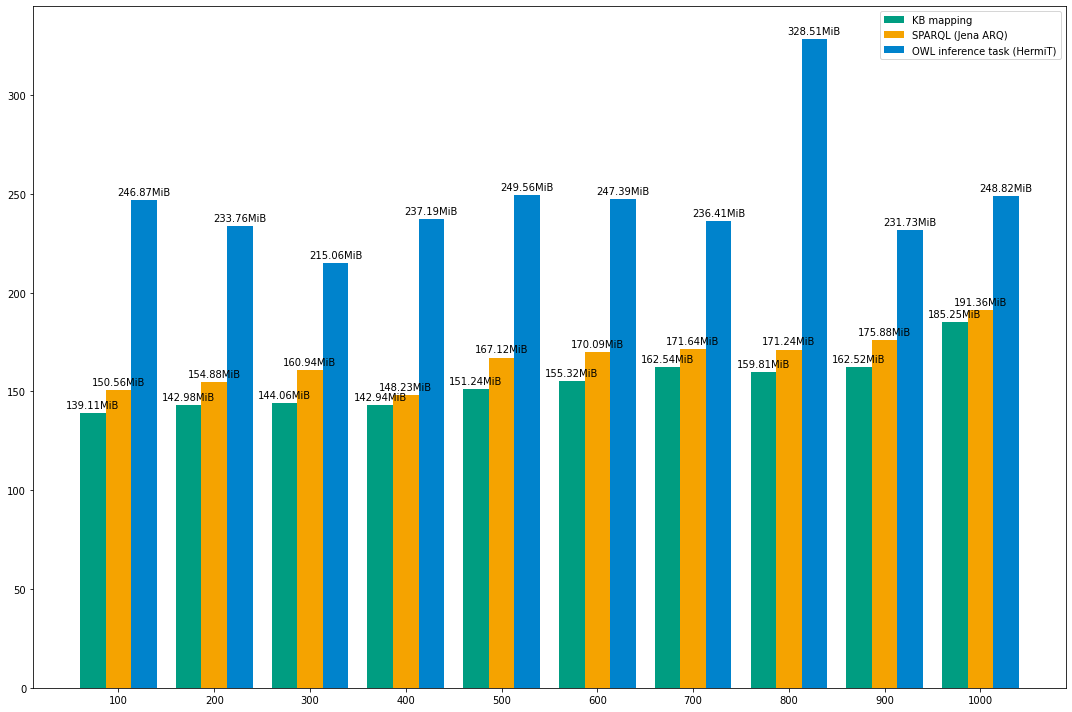

In [31]:
plotTaskMemoryComparison(experimentBStore, ymax=None)

# Experiment C

100     2.934215
200     2.937356
300     3.106538
400     3.203142
500     3.668164
600     3.386013
700     3.439600
800     3.796354
900     3.621722
1000    3.737403
Name: times, dtype: float64

100     0.170300
200     0.171300
300     0.169909
400     0.154629
500     0.159171
600     0.138230
700     0.190946
800     0.235506
900     0.150686
1000    0.142637
Name: times, dtype: float64

100     2.256363
200     2.204311
300     2.054087
400     2.070056
500     1.951852
600     2.213180
700     2.226028
800     2.147958
900     1.939681
1000    2.675947
Name: times, dtype: float64

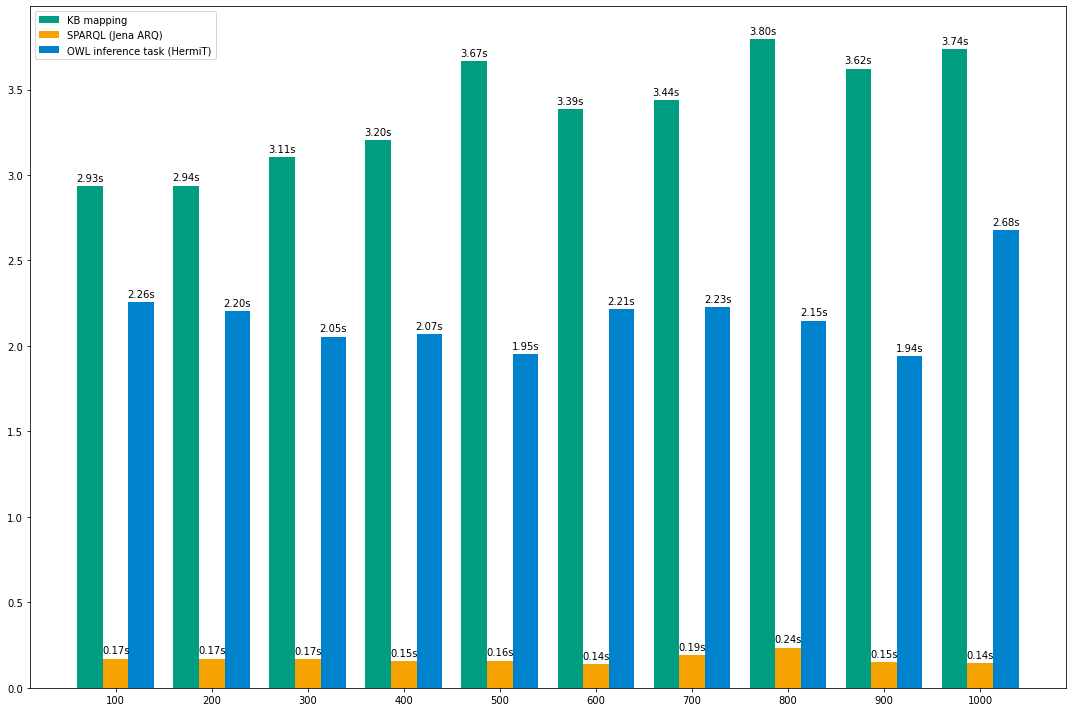

In [32]:
plotTaskTimeComparison(experimentCStore, ymax=None)

100     151.626129
200     150.971977
300     155.736862
400     149.366127
500     161.256004
600     165.096565
700     166.198280
800     168.753853
900     175.423691
1000    172.166412
Name: memory, dtype: float64

100     161.789391
200     164.844765
300     175.682549
400     150.260925
500     176.637413
600     175.187096
700     181.354179
800     182.642502
900     183.689270
1000    197.426079
Name: memory, dtype: float64

100     295.559334
200     231.880501
300     236.684364
400     222.089127
500     305.191399
600     299.422874
700     257.500214
800     291.762329
900     278.048882
1000    288.534554
Name: memory, dtype: float64

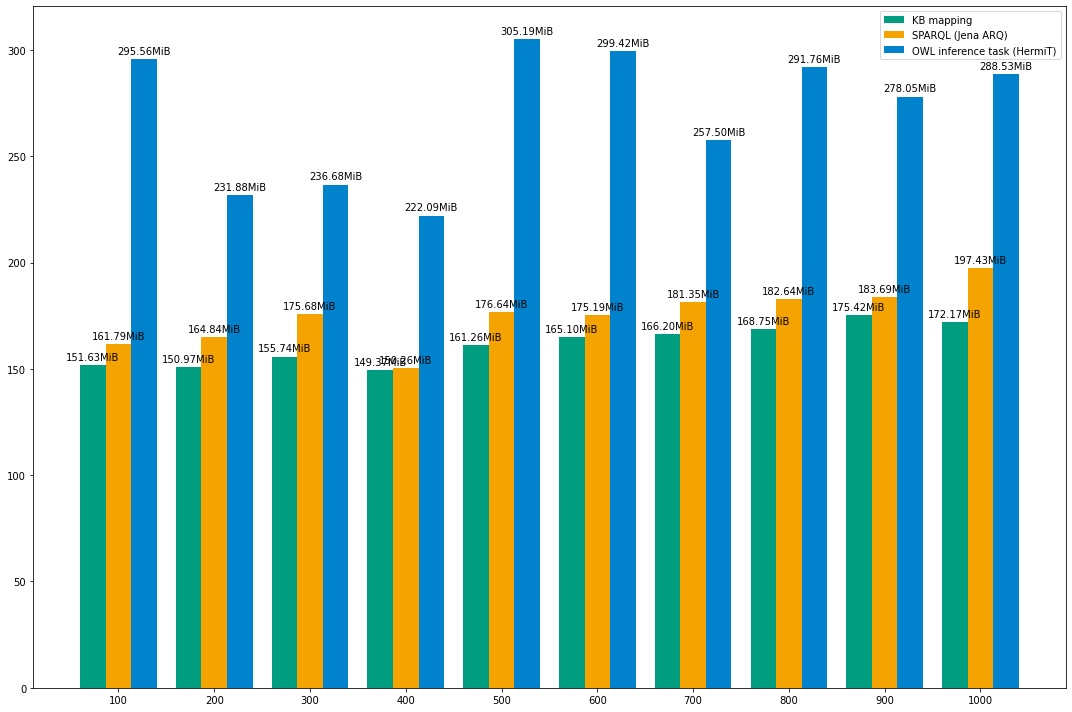

In [33]:
plotTaskMemoryComparison(experimentCStore, ymax=None)

# Experiment D

100      3.957248
200      4.860557
300      5.434780
400      5.036150
500     14.842018
600     10.213999
700      7.231588
800      8.302391
900     11.009941
1000     8.430885
Name: times, dtype: float64

100     0.208658
200     0.149146
300     0.143071
400     0.181397
500     0.220632
600     0.196901
700     0.119363
800     0.146279
900     0.160066
1000    0.149408
Name: times, dtype: float64

100      3.350667
200      5.004210
300      5.595117
400      7.188337
500     23.834647
600     12.496149
700     10.823168
800     11.271466
900     12.541142
1000    11.252985
Name: times, dtype: float64

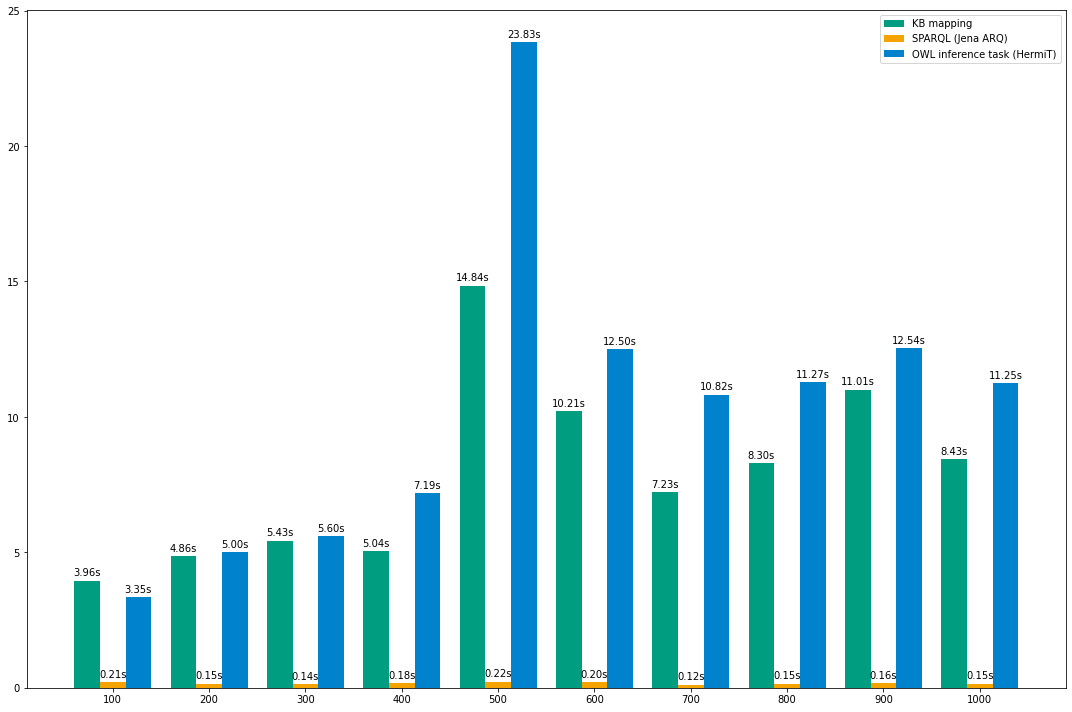

In [34]:
plotTaskTimeComparison(experimentDStore, ymax=None)

100     156.130295
200     185.988899
300     213.999596
400     194.135757
500     258.734787
600     310.626060
700     332.709404
800     365.538536
900     338.854195
1000    466.689873
Name: memory, dtype: float64

100     194.537598
200     196.957588
300     209.941376
400     231.458054
500     285.178940
600     326.053673
700     363.448341
800     355.172783
900     387.167862
1000    366.297707
Name: memory, dtype: float64

100     364.851555
200     376.826584
300     480.243652
400     523.255394
500     747.411140
600     717.092896
700     615.550781
800     690.150253
900     748.525246
1000    672.329041
Name: memory, dtype: float64

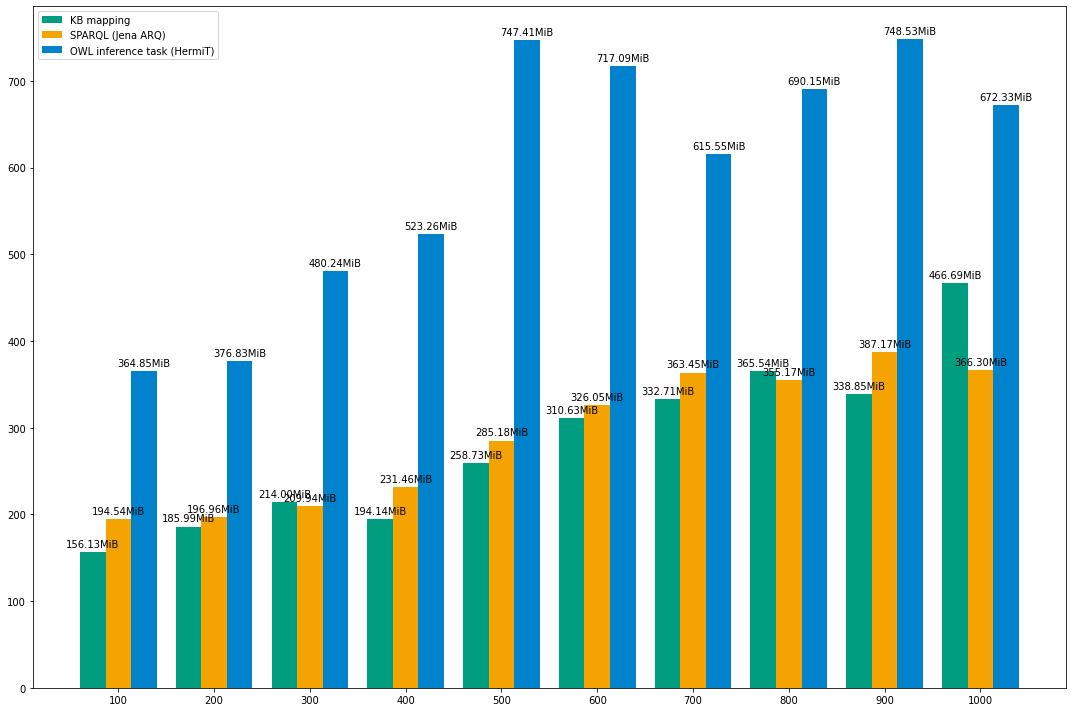

In [2]:
plotTaskMemoryComparison(experimentDStore, ymax=None)

# Experiment E

## buildkb

times
100  100  0 days 00:00:03.268463
     200  0 days 00:00:03.199849
     300  0 days 00:00:03.203557
     400  0 days 00:00:03.381148
     500  0 days 00:00:03.797558
...                          ...
1000 600  0 days 00:00:08.884933
     700  0 days 00:00:10.566074
     800  0 days 00:00:13.296956
     900  0 days 00:00:14.694561
     1000 0 days 00:00:18.827296

[100 rows x 1 columns]

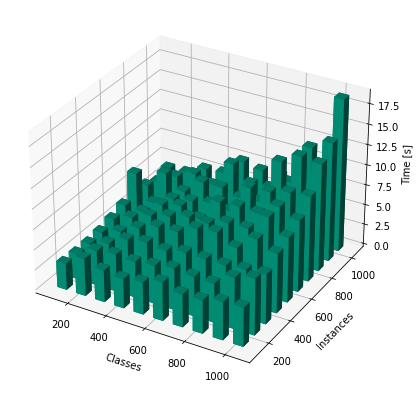

In [8]:
plotTime3D(experimentEStore, 'buildkb')

memory
100  100   165431696.0
     200   184549104.0
     300   163086040.0
     400   189190376.0
     500   164431328.0
...                ...
1000 600   489845184.0
     700   460326032.0
     800   438169096.0
     900   555283040.0
     1000  487513176.0

[100 rows x 1 columns]

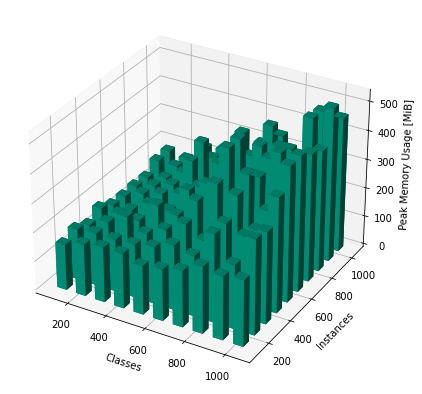

In [9]:
plotMemory3D(experimentEStore, 'buildkb')

## sparql

times
100  100  0 days 00:00:00.176711
     200  0 days 00:00:00.139195
     300  0 days 00:00:00.137054
     400  0 days 00:00:00.142152
     500  0 days 00:00:00.268619
...                          ...
1000 600  0 days 00:00:00.135144
     700  0 days 00:00:00.179441
     800  0 days 00:00:00.130493
     900  0 days 00:00:00.121953
     1000 0 days 00:00:00.171971

[100 rows x 1 columns]

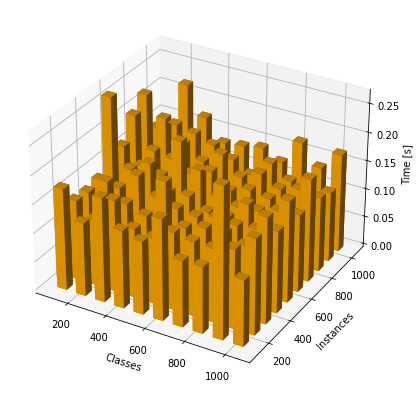

In [10]:
plotTime3D(experimentEStore, 'sparql')

memory
100  100   168721584.0
     200   199074336.0
     300   167118144.0
     400   170437568.0
     500   168499280.0
...                ...
1000 600   403450872.0
     700   468169912.0
     800   500103952.0
     900   585692536.0
     1000  552935416.0

[100 rows x 1 columns]

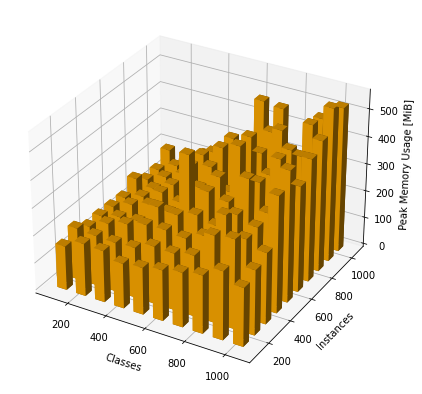

In [12]:
plotMemory3D(experimentEStore, 'sparql')

## infer

times
100  100  0 days 00:00:03.116223
     200  0 days 00:00:04.282921
     300  0 days 00:00:03.599087
     400  0 days 00:00:03.826692
     500  0 days 00:00:05.157594
...                          ...
1000 600  0 days 00:00:17.140993
     700  0 days 00:00:19.745774
     800  0 days 00:00:27.779973
     900  0 days 00:00:41.541505
     1000 0 days 00:00:44.362686

[100 rows x 1 columns]

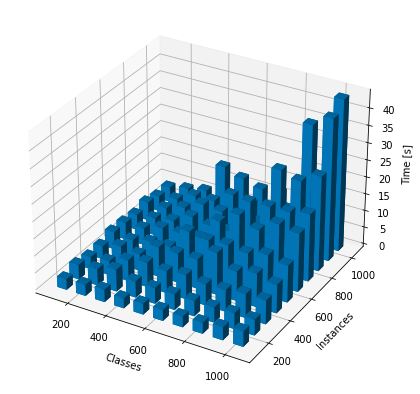

In [13]:
plotTime3D(experimentEStore, 'infer')

memory
100  100   308306808.0
     200   435804504.0
     300   448627640.0
     400   511300064.0
     500   480777400.0
...                ...
1000 600   755213976.0
     700   868261440.0
     800   894089544.0
     900   964188360.0
     1000  843759624.0

[100 rows x 1 columns]

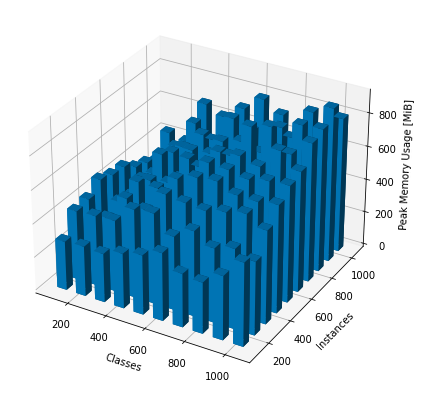

In [14]:
plotMemory3D(experimentEStore, 'infer')